## Klassifikation menschlicher Aktivitäten mittels klassischer Machine-Learning-Modelle


In diesem Teil des Projekts werden klassische Machine-Learning-Modelle auf sensorbasierten Zeitreihendaten eingesetzt, um menschliche Aktivitäten zu klassifizieren – konkret: Gehen (walk), Laufen (run), Sitzen (sitting) und Bergaufgehen (climbing).

Die untersuchten Algorithmen sind:

* Random Forest
* Support Vector Machine (SVM)
* K-Nearest Neighbors (KNN)

Ziel der Analyse ist es, die drei Modelle anhand etablierter Leistungskennzahlen – Accuracy, Precision, Recall und F1-Score – systematisch zu vergleichen und dabei eine Klassifikationsgenauigkeit von mindestens 90 % zu erreichen.

 **Struktur des Notebooks**

 1. Vorbereitung & Datenexploration

 2. Training jedes Modells + Feature‑Importance

 3. Konsolidierter Modellvergleich

### **1. Vorbereitung**

Im ersten Schritt bereite ich die Daten für das Trainieren unserer Modelle vor. Ziel ist es, eine saubere und konsistente Eingabematrix für die Klassifikation zu erzeugen. Dazu zählen das Einlesen der vorverarbeiteten Zeitfensterdaten, die Aufteilung in Trainings- und Testdatensatz sowie eine Standardisierung der Eingabefeatures. Zustätzlich befinden sich in diesem Teil alle imports für dieses Notebook.

In [1]:
import sys
import os
import pandas as pd
import rootutils
import numpy as np
from pathlib import Path

np.random.seed(123)

notebook_dir = Path().resolve()
project_root = notebook_dir.parent

print(f"Projektpfad: {project_root}")
os.chdir(project_root)

from src.methods import *
from src.utils import *

ndl_path = Path("data/processed/NDL")


Projektpfad: /Users/denizhatemo/Desktop/CDL1Challenge/CDL1-MChallenge


In [2]:
train_files = [
    "features_train.csv",
    "features_train_aug.csv",
    "features_train_flip_roll.csv",
    "features_train_invert_pitch.csv",
    "features_train_rotate_yaw_180.csv"
]

# Alle DataFrames laden und zusammenfügen
df_list = [pd.read_csv(ndl_path / f) for f in train_files]
df_train_all = pd.concat(df_list, ignore_index=True)

df_test = pd.read_csv(ndl_path / "features_test.csv")

X_train = df_train_all.drop(columns=["label"])
y_train = df_train_all["label"]

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

#### **1.1. Datenaufbereitung**


**Train & Test Datensatz**

In diesem Zwischenschritt werden die Datensätze Test und Train eingelesen und in *X* und *y* unterteilt, wobei letzteres nur die Zielvariable *label* beinhaltet. Für das Trainieren der Modelle wedern die *X* datensätze benutzt.


In [3]:
from collections import Counter
print("Train-Klassenverteilung:", Counter(y_train))
print("Test-Klassenverteilung:", Counter(y_test))

Train-Klassenverteilung: Counter({'climbing': 6670, 'walking': 6445, 'sitting': 6220, 'joggen': 5755})
Test-Klassenverteilung: Counter({'climbing': 156, 'sitting': 141, 'walking': 137, 'joggen': 127})


#### **1.2. Hauptkomponentenanalyse (PCA)**

Um die hohe Dimensionalität und Multikollinearität der sensorbasierten Eingabedaten zu adressieren, wurde eine Hauptkomponentenanalyse (PCA) durchgeführt. Ziel war es, eine kompaktere Repräsentation der Daten zu finden, die dennoch den Grossteil der erklärbaren Varianz beibehält. Eine solche Reduktion hilft, das Overfitting-Risiko zu senken, die Rechenzeit zu reduzieren und die Robustheit der nachfolgenden Klassifikationsmodelle zu erhöhen.

Die PCA wurde auf den standardisierten Trainingsdaten angewendet. Als Kriterium für die Beibehaltung von Hauptkomponenten wurde eine kumulierte erklärte Varianz von mindestens 95 % definiert.

Totale ursprüngliche Features : 76
Reduziert auf Hauptkomponenten: 19
Erklärte Varianz durch PCA    : 0.9502


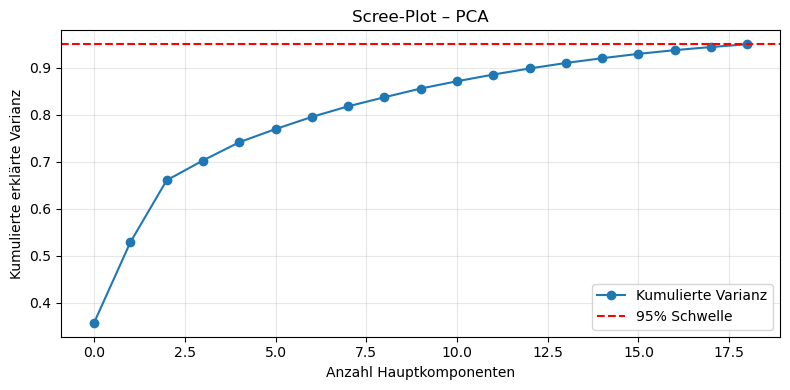

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# 1. Daten skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2. PCA mit Varianz-Schwelle
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3. Informationen zur Reduktion
total_features = X_train.shape[1]
retained_components = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"Totale ursprüngliche Features : {total_features}")
print(f"Reduziert auf Hauptkomponenten: {retained_components}")
print(f"Erklärte Varianz durch PCA    : {explained_variance:.4f}")

# 4. Scree-Plot (kumulative erklärte Varianz)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', label='Kumulierte Varianz')
plt.axhline(0.95, color='red', linestyle='--', label='95% Schwelle')
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Kumulierte erklärte Varianz")
plt.title("Scree-Plot – PCA")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# Ladungsmatrix: 
loadings = pd.DataFrame(
    pca.components_,                # shape: (n_components, n_features)
    columns=X_train.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Absolutwerte zur Bewertung des Einflusses (je höher, desto mehr Einfluss)
abs_loadings = loadings.abs()

# Gesamtbeitrag jedes ursprünglichen Features über alle PCs aufsummieren
total_feature_contribution = abs_loadings.sum(axis=0).sort_values(ascending=False)

top_19_original_features = total_feature_contribution.head(19)
print("---Top 19 Originalfeatures mit grösstem Einfluss auf PCA---")
print(top_19_original_features)

---Top 19 Originalfeatures mit grösstem Einfluss auf PCA---
gyroscope_x_mean          2.813244
gyroscope_y_mean          2.725404
accelerometer_z_mean      2.700135
orientation_roll_std      2.502261
gyroscope_z_mean          2.435157
orientation_qw_mean       2.348881
accelerometer_y_mean      2.145678
orientation_roll_max      2.132808
orientation_pitch_mean    2.105604
magnetometer_x_max        2.099769
orientation_roll_min      2.023126
gravity_x_min             2.019429
magnetometer_z_max        2.009278
orientation_qz_mean       1.987791
magnetometer_z_mean       1.927777
orientation_pitch_max     1.889847
magnetometer_x_mean       1.888379
orientation_qx_mean       1.876460
magnetometer_x_min        1.865750
dtype: float64


### **1.2.1. Ergebnisse der PCA**

Die Scree-Plot-Analyse zeigt, dass **bereits 19 Hauptkomponenten ausreichen**, um **95,02 % der Gesamtvarianz** des ursprünglichen 76-dimensionalen Merkmalsraums zu erklären. Dies entspricht einer effektiven Reduktion auf weniger als ein Viertel der Ursprungsdimension, bei gleichzeitig minimalem Informationsverlust.

Diese Merkmale stammen aus den folgenden Sensorsystemen:

- **Gyroskop**: `gyroscope_x_mean`, `gyroscope_y_mean`, `gyroscope_z_mean`
- **Beschleunigungssensor**: `accelerometer_z_mean`, `accelerometer_y_mean`
- **Orientierungssensor**: `orientation_roll_std`, `orientation_roll_max`, `orientation_roll_min`, `orientation_pitch_mean`, `orientation_pitch_max`, `orientation_qw_mean`, `orientation_qz_mean`, `orientation_qx_mean`
- **Magnetometer**: `magnetometer_x_max`, `magnetometer_z_max`, `magnetometer_z_mean`, `magnetometer_x_mean`, `magnetometer_x_min`
- **Gravitationssensor**: `gravity_x_min`

Diese Merkmale zeigen besonders starke Projektionen in den Hauptkomponenten und sind somit wesentlich für die Unterscheidung der Aktivitätsklassen. Die Kombination aus Bewegungs-, Lage- und Magnetfeldinformationen scheint entscheidend für die Klassifikationsleistung zu sein.

Die so gewonnenen reduzierten Dimensionen werden im weiteren Verlauf der Analyse als Input für die Klassifikationsmodelle verwendet.

### **2. Klassischer Machine-Learning-Modelle**

In diesem Teil des Projekts werden klassische Machine-Learning-Modelle auf sensorbasierten Zeitreihendaten eingesetzt, um menschliche Aktivitäten zu klassifizieren – konkret: Gehen (walking), Joggen (joggen), Sitzen (sitting) und Bergaufgehen (climbing).

Die untersuchten Algorithmen sind:

* Random Forest
* Support Vector Machine (SVM)
* K-Nearest Neighbors (KNN)

Ziel der Analyse ist es, die drei Modelle anhand etablierter Leistungskennzahlen – Accuracy, Precision, Recall und F1-Score – systematisch zu vergleichen und dabei eine Klassifikationsgenauigkeit von mindestens 90 % zu erreichen.

Für alle drei Machine-Learning-Modelle wurde ein einheitliches Modellierungsframework verwendet. Die Modellarchitektur basiert jeweils auf einer Pipeline, die folgende Schritte umfasst:

* **Standardisierung** der Eingabedaten mit `StandardScaler`.
* **Dimensionsreduktion** mittels `PCA` (95 % erklärte Varianz) – *ausgenommen beim Random Forest, da dieser algorithmisch robust gegenüber Multikollinearität ist und durch PCA potenziell interpretierbare Strukturen verliert.*
* **Klassifikation** mit dem jeweiligen Algorithmus (RF, SVM oder KNN).

Zur Modelloptimierung wurde für alle Modelle eine **GridSearchCV** mit 5-facher Kreuzvalidierung verwendet. Dabei wurde der `accuracy`-Score als Optimierungskriterium herangezogen. Die einheitliche Vorgehensweise ermöglicht einen fairen und nachvollziehbaren Vergleich der Modellleistungen.

Darüber hinaus wird ein **Modellvergleichstracker** eingerichtet, der für jedes Klassifikationsmodell die zentralen Leistungskennzahlen – Accuracy, Precision (macro), Recall (macro) und F1-Score (macro) – sowohl für Trainings- als auch Testdaten systematisch speichert. 

Die Verwendung des *macro*-Durchschnitts ist besonders geeignet, da er für jede Klasse den jeweiligen Metrikwert berechnet und anschliessend den arithmetischen Mittelwert über alle Klassen bildet – unabhängig von deren Häufigkeit. Dies gewährleistet, dass auch seltener vertretene Klassen (wie z. B. „joggen“) gleichwertig in die Bewertung einfliessen. Ein *macro*-basierter Vergleich ist somit fairer und informativer in Fällen mit Klassenungleichgewicht, wie es auch im vorliegenden Datensatz zu beobachten ist.

Der Tracker ermöglicht am Ende eine konsistente und transparente Gegenüberstellung aller Modelle auf Basis einheitlicher Bewertungsmassstäbe und bildet die Grundlage für eine fundierte Auswahl des besten Klassifikators.


#### **Auswertungs- und Vergleichsfunktion für Machine-Learning-Modelle**

Zur systematischen Bewertung und zum Vergleich der trainierten Klassifikationsmodelle wurde eine zentrale Evaluationsfunktion implementiert. Diese Funktion übernimmt mehrere Aufgaben, um sowohl die Leistungsfähigkeit als auch das Generalisierungsverhalten der Modelle umfassend zu analysieren und zu dokumentieren.

**1. Metrikspeicherung im Vergleichstracker**

Ein globaler **Modellvergleichstracker** (`model_metrics`) wird initialisiert, um die Leistungskennzahlen aller Modelle strukturiert zu speichern. Für jedes Modell werden Accuracy, Precision, Recall und F1-Score sowohl für das Trainings- als auch für das Testset hinterlegt. Die Speicherung erfolgt als geordnete Dictionaries, was eine spätere strukturierte Ausgabe ermöglicht.

**2. Performanceberechnung & Visualisierung**

Die Funktion `evaluate_model()` übernimmt die folgenden Schritte:

- **Vorhersageberechnung:** Das trainierte Modell generiert Vorhersagen für Trainings- und Testdaten. Falls die Zielvariablen ursprünglich kodiert wurden (z. B. mit `LabelEncoder`), erfolgt optional eine Rücktransformation zur besseren Interpretierbarkeit.
- **Berechnung zentraler Metriken:** Für beide Datensätze werden Accuracy, Precision, Recall und F1-Score im *macro*-Schnitt berechnet.
- **Konfusionsmatrizen:** Für Training und Test wird jeweils eine heatmap-basierte Konfusionsmatrix ausgegeben, um Fehlklassifikationen visuell darzustellen und Klassenschwächen zu identifizieren.

**3. Overfitting-Diagnose**

Zur automatischen Bewertung des Generalisierungsverhaltens werden Schwellenwerte für die Differenz zwischen Trainings- und Testmetrik definiert: Wird ein Unterschied von mehr als 5 Prozentpunkten bei Accuracy oder F1-Score festgestellt (Δ > 0.05), wird eine entsprechende Warnung ausgegeben.


**4. ROC-Kurven für mehrklassige Modelle**

Falls das Modell Wahrscheinlichkeiten (`predict_proba`) ausgeben kann, werden **ROC-Kurven** für jede Klasse erstellt, sofern ausreichend Testbeispiele vorhanden sind. Die Kurven zeigen die Sensitivität (TPR) gegenüber der Falsch-Positiv-Rate (FPR) und erlauben Rückschlüsse auf die Trennschärfe des Modells bei verschiedenen Klassengrenzen.

**5. Lernkurvenanalyse**

Mittels einer externen Hilfsfunktion (`utils.plot_learning_curve`) wird für jedes Modell zusätzlich eine **Lernkurve** erzeugt, die den Zusammenhang zwischen Trainingsumfang und Modellgüte zeigt. Dies dient der Einschätzung, ob das Modell von mehr Daten profitieren könnte oder ob es bereits ein Sättigungsniveau erreicht hat.


---

#### **2.1. Random Forest**

Random Forest ist ein leistungsfähiges Ensembleverfahren, das eine Vielzahl an Entscheidungsbäumen kombiniert, um robuste Vorhersagen zu treffen. Für jeden Baum werden zufällig Subsets von Features und Beobachtungen gezogen (Bagging-Prinzip), wodurch Varianz reduziert und Overfitting vorgebeugt wird. Aufgrund dieser Eigenschaften ist das Modell besonders geeignet für hochdimensionale Datensätze wie Sensordaten.

Random Forests sind weitgehend unempfindlich gegenüber Multikollinearität und benötigen keine explizite Normierung oder Dimensionsreduktion - Deswegen wird hier der PCA nicht eingesetzt.



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Bester CV-Score (Accuracy): 0.9987
Bestes Modell: Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_split=5,
                                        n_estimators=200, random_state=42))])

— Training —
Acc 0.9995 | Prec 0.9995 | Rec 0.9995 | F1 0.9995


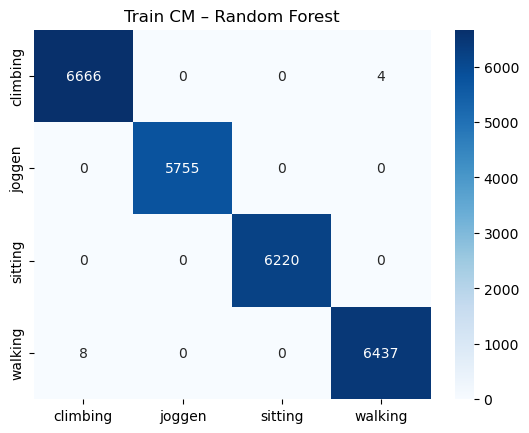


— Test —
Acc 0.9893 | Prec 0.9892 | Rec 0.9891 | F1 0.9889


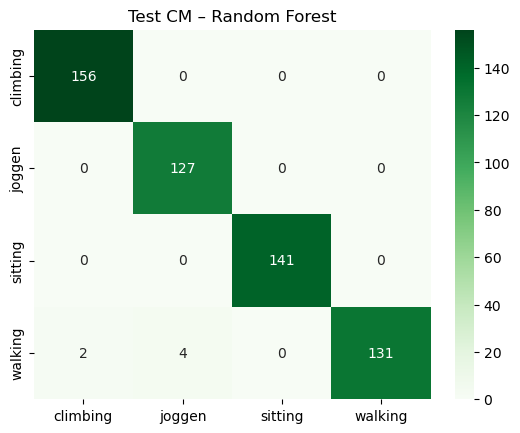

✅  Generalisierung in Ordnung


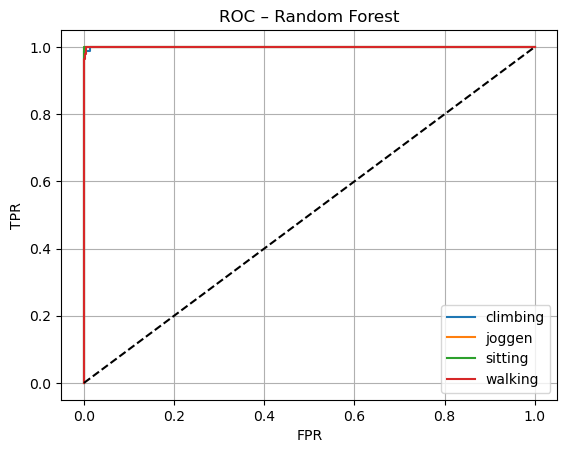

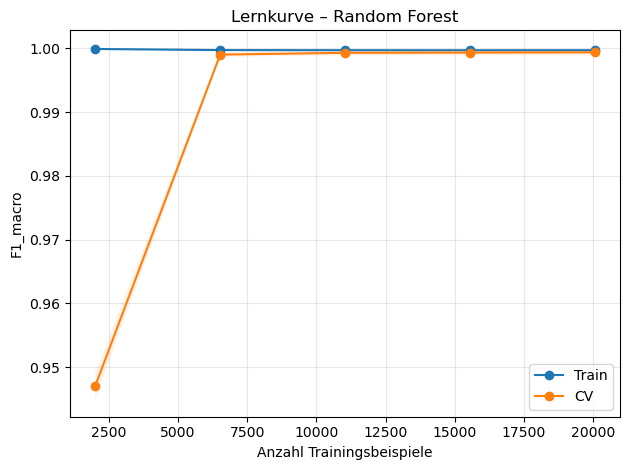

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + Random Forest
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('clf', RandomForestClassifier(random_state=42))
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für GridSearchCV
param_grid_rf = {
    'clf__n_estimators': [100, 200],    # Anzahl der Bäume
    'clf__max_depth': [3, 5, 7],   # Maximale Baumtiefe
    'clf__min_samples_split': [2, 5]    # Min. Samples zum Split
}

# ---------------------------------------------------------------------------
# GridSearchCV mit 5-facher Kreuzvalidierung (Accuracy als Scoring)
grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training auf Trainingsdaten
grid_rf.fit(X_train, y_train)

# Beste Parameter und CV-Score ausgeben
print(f"Bester CV-Score (Accuracy): {grid_rf.best_score_:.4f}")

# ---------------------------------------------------------------------------
# Vorhersage auf Testdaten & Trainingsdaten
y_train_pred = grid_rf.predict(X_train)
y_test_pred = grid_rf.predict(X_test)

# Bestes Modell extrahieren
best_model = grid_rf.best_estimator_
print(f"Bestes Modell: {best_model}")

# Evaluation und Speichern der Ergebnisse
evaluate_model("Random Forest", best_model, X_train, y_train, X_test, y_test)

Anzahl Features nach Preprocessing: 76
Feature-Namen Beispiele: ['accelerometer_x_mean' 'accelerometer_x_std' 'accelerometer_x_min'
 'accelerometer_x_max' 'accelerometer_y_mean']

--- Top 10 Features by Permutation Importance ---
   Rank              Feature  Importance       Std
0     1  magnetometer_y_mean    0.003446  0.001894
1     2  accelerometer_x_std    0.002852  0.003074
2     3  accelerometer_z_std    0.002436  0.002323
3     4   magnetometer_y_max    0.002436  0.001811
4     5       gravity_z_mean    0.002258  0.001779
5     6   orientation_qy_max    0.001307  0.000788
6     7  orientation_qy_mean    0.001188  0.000840
7     8  accelerometer_z_min    0.001129  0.000859
8     9   magnetometer_x_max    0.001070  0.000873
9    10  accelerometer_z_max    0.001070  0.002283


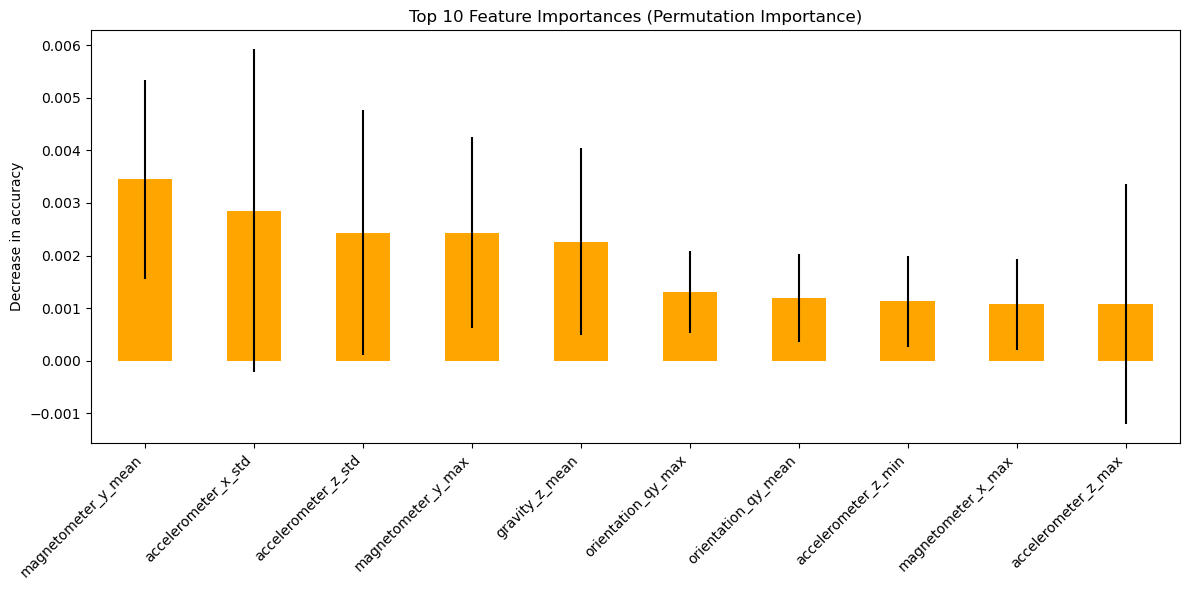


--- Grouped Feature Importances by Sensor ---
   Rank   Sensor Group  Total Importance
0     1   magnetometer          0.004753
1     2    orientation          0.002793
2     3        gravity          0.001367
3     4      gyroscope         -0.000713
4     5  accelerometer         -0.011230


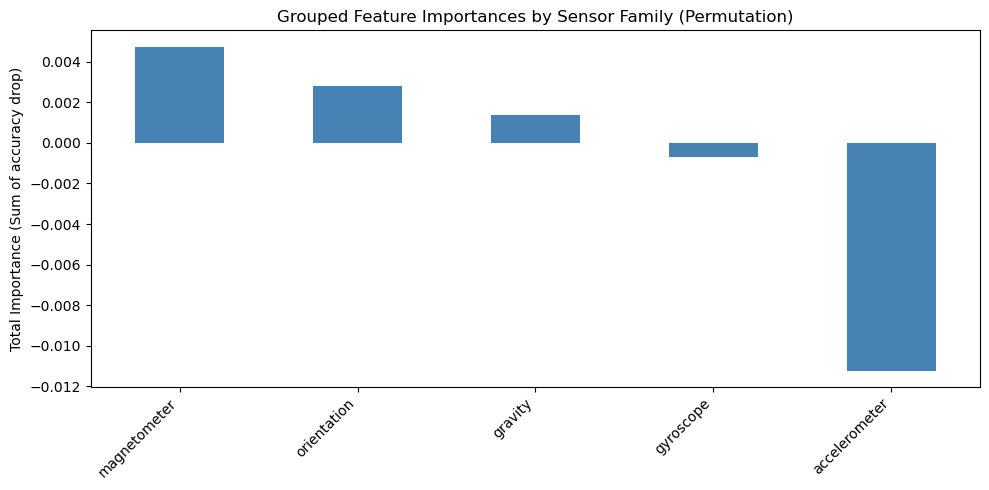

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Extract model from pipeline
best_rf_pipeline = grid_rf.best_estimator_
best_rf = best_rf_pipeline.named_steps["clf"]

# Retrieve test data after preprocessing (inkl. PCA falls vorhanden)
X_test_processed = best_rf_pipeline[:-1].transform(X_test)
y_test_true = y_test

# Berechne Permutation Feature Importance
pfi_result = permutation_importance(
    best_rf, X_test_processed, y_test_true,
    n_repeats=30, random_state=42, n_jobs=-1,
    scoring='accuracy'
)

# Robuste Feature-Namen Extraktion nach Preprocessing
try:
    if hasattr(best_rf_pipeline[:-1], 'get_feature_names_out'):
        feature_names = best_rf_pipeline[:-1].get_feature_names_out()
    else:
        # Fallback: verwende ursprüngliche Namen falls verfügbar
        if hasattr(X_train, 'columns') and len(X_train.columns) == pfi_result.importances_mean.shape[0]:
            feature_names = X_train.columns[:pfi_result.importances_mean.shape[0]]
        else:
            feature_names = [f'feature_{i}' for i in range(pfi_result.importances_mean.shape[0])]
except:
    feature_names = [f'feature_{i}' for i in range(pfi_result.importances_mean.shape[0])]

# Prüfen, ob Dimensionen übereinstimmen
if len(feature_names) != pfi_result.importances_mean.shape[0]:
    print(f"Warnung: Anzahl Feature-Namen ({len(feature_names)}) != Anzahl Importances ({pfi_result.importances_mean.shape[0]})")
    feature_names = [f'feature_{i}' for i in range(pfi_result.importances_mean.shape[0])]

print(f"Anzahl Features nach Preprocessing: {len(feature_names)}")
print(f"Feature-Namen Beispiele: {feature_names[:5]}")

# Top 10 Features
importances_mean = pfi_result.importances_mean
importances_std = pfi_result.importances_std

forest_importances = pd.Series(importances_mean, index=feature_names)
std_series = pd.Series(importances_std, index=feature_names)

top_10_features = forest_importances.nlargest(10)
top_10_std = std_series[top_10_features.index]

# DataFrame zur Anzeige
top_10_df = pd.DataFrame({
    "Feature": top_10_features.index,
    "Importance": top_10_features.values,
    "Std": top_10_std.values,
})
top_10_df["Rank"] = np.arange(1, len(top_10_df) + 1)
top_10_df = top_10_df[["Rank", "Feature", "Importance", "Std"]]

print("\n--- Top 10 Features by Permutation Importance ---")
print(top_10_df)

# Plot der Top 10
fig, ax = plt.subplots()
top_10_features.plot.bar(yerr=top_10_std, ax=ax, color='orange')
ax.set_title("Top 10 Feature Importances (Permutation Importance)")
ax.set_ylabel("Decrease in accuracy")
plt.xticks(rotation=45, ha='right')
fig.set_size_inches(12, 6)
fig.tight_layout()
plt.show()

# Gruppierte Feature Importances (nach Präfix) - nur wenn sinnvoll
grouped_importances = {}
grouping_possible = True

# Prüfen ob Gruppierung nach Präfix sinnvoll ist
sample_features = feature_names[:5] if len(feature_names) >= 5 else feature_names
if all('_' not in str(feature) for feature in sample_features):
    print("\n--- Hinweis: Gruppierung nach Sensor-Präfix nicht möglich ---")
    print("Feature-Namen enthalten keine Unterstriche (möglicherweise durch PCA transformiert)")
    grouping_possible = False

if grouping_possible:
    for feature, importance in forest_importances.items():
        try:
            prefix = str(feature).split("_")[0]
            grouped_importances[prefix] = grouped_importances.get(prefix, 0.0) + importance
        except:
            # Falls split nicht funktioniert, verwende ganzen Namen
            grouped_importances[str(feature)] = importance

    if grouped_importances:
        grouped_importances_series = pd.Series(grouped_importances).sort_values(ascending=False)

        grouped_df = grouped_importances_series.reset_index()
        grouped_df.columns = ["Sensor Group", "Total Importance"]
        grouped_df["Rank"] = np.arange(1, len(grouped_df) + 1)
        grouped_df = grouped_df[["Rank", "Sensor Group", "Total Importance"]]

        print("\n--- Grouped Feature Importances by Sensor ---")
        print(grouped_df)

        plt.figure(figsize=(10, 5))
        grouped_importances_series.plot(kind='bar', color='steelblue')
        plt.title("Grouped Feature Importances by Sensor Family (Permutation)")
        plt.ylabel("Total Importance (Sum of accuracy drop)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("Erstelle Alternative: Top Features ohne Gruppierung")
    
    # Alternative Visualisierung: Alle Features (nicht nur Top 10)
    all_features_sorted = forest_importances.sort_values(ascending=False)
    
    plt.figure(figsize=(12, 8))
    if len(all_features_sorted) > 20:
        # Zeige nur Top 20 wenn zu viele Features
        plot_features = all_features_sorted.head(20)
        title_suffix = " (Top 20)"
    else:
        plot_features = all_features_sorted
        title_suffix = ""
    
    plot_features.plot(kind='bar', color='steelblue')
    plt.title(f"All Feature Importances (Permutation){title_suffix}")
    plt.ylabel("Decrease in accuracy")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

##### **2.1.1. Ergebnisdiskussion - Random Forest**

Der Random Forest erzielt auf dem Trainingsdatensatz sehr hohe Werte (Accuracy und F1-Score = 99,95 %). Auf dem Testdatensatz erreicht das Modell eine Accuracy von 98,93 % mit einer geringen, aber erkennbaren Generalisierungslücke von etwa 1 %. Diese moderate Differenz ist durchaus akzeptabel und zeigt, dass das Modell gut generalisiert, ohne stark zu überfitten.

**Einfluss der Datenaugmentation:** 

Die ursprünglichen Messungen wurden unter sehr kontrollierten, "sterilen" Bedingungen durchgeführt – das Smartphone befand sich immer in derselben Hosentasche und in identischer Position. Um die Realitätsnähe zu erhöhen und die Generalisierungsfähigkeit auf neue, variierende Einsatzbedingungen zu verbessern, wurden die Daten augmentiert. Diese Augmentation simuliert natürliche Variationen in der Smartphone-Position und -orientierung, wie sie im täglichen Gebrauch auftreten. Dies erklärt auch die realistischere Generalisierungslücke im Vergleich zu den ursprünglich nahezu perfekten Werten.

Ein möglicher Grund für die starke Performance von Random Forests ist, dass sie durch das Aggregieren vieler Entscheidungsbäume besonders robuste und flexible Modelle darstellen. Sie können komplexe, nichtlineare Zusammenhänge in den Daten erfassen und sind dabei weniger anfällig für Überanpassung als einzelne Bäume. Wie Géron (2019) beschreibt:  

*Random Forests generally work well even without much hyperparameter tuning, and they are less prone to overfitting than individual decision trees, thanks to the averaging of multiple trees.* 

Die Bewertung der Feature-Wichtigkeit erfolgte hier mit **Permutation Feature Importance (PFI)**. Dabei wird für jedes Merkmal die Auswirkung auf die Modellgenauigkeit gemessen, indem man den jeweiligen Featurevektor permutiert und beobachtet, wie stark sich die Accuracy verändert. Je grösser die Veränderung, desto wichtiger das Merkmal. Im Gegensatz zur klassischen *Mean Decrease in Impurity* (MDI) basiert diese Methode auf den **Testdaten** und liefert dadurch robustere und realistischere Aussagen zur tatsächlichen Bedeutung eines Merkmals im Einsatz. (Terence Shin, 2024)

Die Ergebnisse der gruppierten Sensoranalyse zeigen überraschende Erkenntnisse: **Magnetometer-Features** erweisen sich als die wertvollsten für das Modell, gefolgt von **Orientation**- und **Gravity**-Sensoren. Besonders auffällig ist der stark negative Beitrag der **Accelerometer-Features**, was darauf hindeutet, dass diese Sensordaten möglicherweise Rauschen enthalten oder redundante Informationen liefern, die die Modellleistung beeinträchtigen. Dies könnte auf die Augmentation zurückzuführen sein, da verschiedene Smartphone-Positionen die Accelerometer-Signale unterschiedlich beeinflussen.

Diese Erkenntnisse legen nahe, dass für zukünftige Modelloptimierungen eine Fokussierung auf Magnetometer- und Orientierungs-Features sowie eine kritische Überprüfung der Accelerometer-Datenqualität sinnvoll wäre.

Insgesamt zeigt das Modell trotz der realistischeren Datenbasis eine sehr gute Generalisierungsfähigkeit und profitiert von der durch Augmentation erhöhten Robustheit gegenüber variierenden Einsatzbedingungen.

**Quellen:**  
- Aurélien Géron (2019): [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), O'Reilly Media.  
- Terence Shin (Built In, 2024): [Understanding Feature Importance in Machine Learning](https://builtin.com/data-science/feature-importance)

---

#### **2.2. Support Vector Machine (SVM)**

Support Vector Machines zielen darauf ab, optimale Trennflächen im Merkmalsraum zu finden, die die Trainingsdaten mit maximalem Abstand (Margin) zwischen den Klassen separieren. Besonders in hochdimensionalen Räumen zeigen SVMs oft sehr gute Generalisierungseigenschaften. Dies macht sie zu einem attraktiven Kandidaten für klassifikatorische Aufgaben auf komplexen Sensordaten.

Da SVMs empfindlich auf die Skalierung der Daten und auf redundante Features reagieren, ist eine vorgelagerte Standardisierung und PCA-Dimensionreduktion hier essenziell. Dies stellt sicher, dass die Distanzen im Raum sinnvoll interpretiert werden können.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Beste Parameter: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Bester CV-Score (Accuracy): 0.7360

— Training —
Acc 0.9947 | Prec 0.9950 | Rec 0.9950 | F1 0.9950


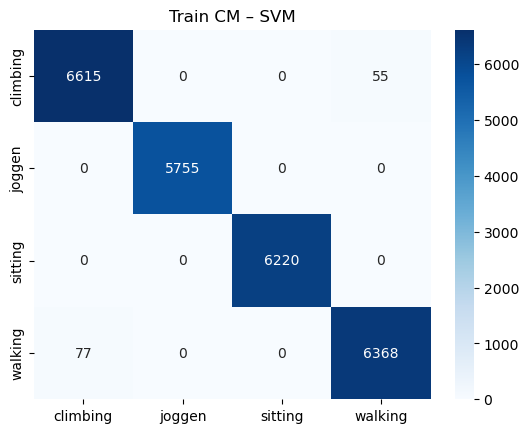


— Test —
Acc 0.9447 | Prec 0.9438 | Rec 0.9459 | F1 0.9440


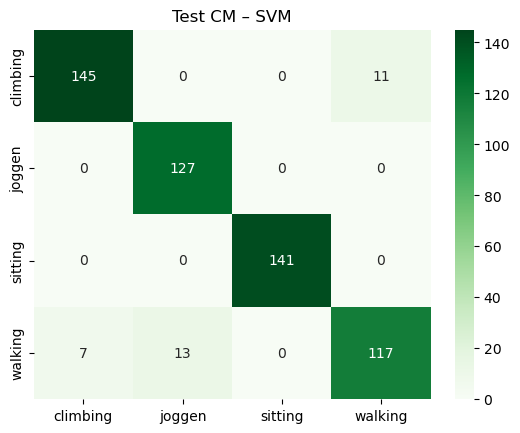

⚠️  Verdacht auf Overfitting   (ΔAcc=0.050, ΔF1=0.051)


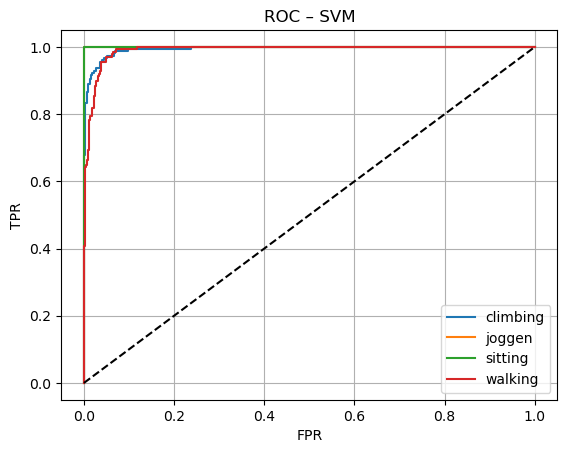

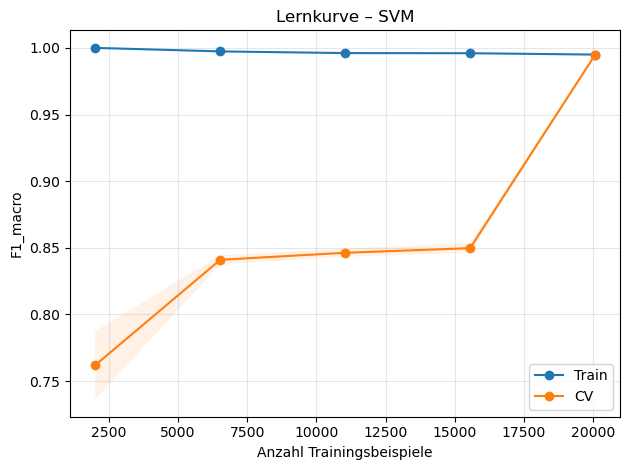

In [8]:
from sklearn.svm import SVC

# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + PCA + SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', SVC(probability=True))
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für GridSearchCV
param_grid_svm = {
    'clf__C': [0.1, 1, 10],          # Regularisierungsparameter
    'clf__kernel': ['rbf', 'linear'],# Kernel-Typ
    'clf__gamma': ['scale', 'auto']  # Gamma für rbf-Kernel
}

# ---------------------------------------------------------------------------
# GridSearchCV mit 5-facher Kreuzvalidierung (Accuracy als Scoring)
grid_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training auf Trainingsdaten
grid_svm.fit(X_train, y_train)
print("Beste Parameter:", grid_svm.best_params_)
print(f"Bester CV-Score (Accuracy): {grid_svm.best_score_:.4f}")

# ---------------------------------------------------------------------------
# Vorhersage auf Testdaten & Trainingsdaten
y_train_pred = grid_svm.predict(X_train)
y_test_pred = grid_svm.predict(X_test)

# Bestes Modell extrahieren
best_model = grid_svm.best_estimator_

# Evaluation und Speichern der Ergebnisse
evaluate_model("SVM", best_model, X_train, y_train, X_test, y_test)


##### **2.2.1 Ergebnisdiskussion - Support Vector Machine (SVM)**

Die Support-Vector-Machine wurde mit einer Pipeline aus Standardisierung und linearem Kernel optimiert. Das beste Hyperparameter-Set ergab *C = 10* bei einem CV-Score von 73,6 %. Die finalen Ergebnisse zeigen eine Training-Accuracy von 99,47 % und eine Test-Accuracy von 94,47 %, was eine deutliche Generalisierungslücke von etwa 5 % aufweist und auf **Overfitting** hindeutet.

**Analyse der Confusion Matrices:**
- **Training:** Nahezu perfekte Klassifikation mit minimalen Fehlern (nur 55 falsche "climbing" als "walking" und 77 falsche "walking" als "climbing")
- **Test:** Deutlich mehr Verwechslungen, insbesondere:
  - 11 "climbing" werden als "walking" klassifiziert
  - 7 "walking" werden als "climbing" klassifiziert  
  - 13 "walking" werden als "jogging" klassifiziert

**Ursachen für das Overfitting:**
1. **Komplexität trotz linearem Kernel:** Auch lineare SVMs können bei hochdimensionalen Daten überfitten, besonders wenn der Regularisierungsparameter *C* zu hoch gewählt wird. Wie Raschka & Mirjalili (2019) erklären: *"Increasing the value of C increases the bias but decreases the variance of the model"* - ein zu hoher C-Wert kann somit zu Überanpassung führen.
2. **Datenaugmentation-Effekt:** Die augmentierten Daten mit variierenden Smartphone-Positionen scheinen für SVMs schwieriger zu generalisieren als für Random Forests
3. **Kreuzvalidierungs-Diskrepanz:** Der niedrige CV-Score von 73,6 % im Vergleich zur hohen Training-Performance deutet bereits während der Optimierung auf Stabilitätsprobleme hin

**ROC-Kurven-Analyse:**
Die ROC-Kurven zeigen dennoch eine gute Klassifikationsleistung für alle Aktivitäten, wobei "jogging" und "sitting" nahezu perfekte AUC-Werte erreichen. Dies deutet darauf hin, dass das Modell prinzipiell die richtigen Muster erkennt, aber zu stark auf Trainingsspezifika optimiert ist.

**Lernkurven-Interpretation:**
Die Lernkurve zeigt das klassische Overfitting-Muster: konstant hohe Training-Performance bei stetig steigender, aber deutlich niedrigerer CV-Performance. Erst bei maximaler Datenmenge (20.000 Samples) nähert sich die CV-Performance der Training-Performance an.

**Vergleich zu Random Forest:**
Im Gegensatz zum Random Forest (Generalisierungslücke ~1 %) zeigt die SVM deutliche Schwächen bei der Generalisierung auf die augmentierten Testdaten. Dies könnte daran liegen, dass Random Forests durch ihr Ensemble-Verfahren robuster gegenüber Datenvariation sind, während SVMs sensitiver auf die durch Augmentation eingeführten Positionsvariationen reagieren.

**Fazit:**
Obwohl SVMs theoretisch gut für die Trennung komplexer Muster geeignet sind, zeigt sich in diesem spezifischen Anwendungsfall mit augmentierten Sensordaten eine deutliche Anfälligkeit für Overfitting. Für praktische Anwendungen wäre eine weitere Regularisierung zu empfehlen.

**Quelle:**  
Sebastian Raschka & Vahid Mirjalili (2019): *Python Machine Learning – Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow*, 3rd Edition, Packt Publishing. 
[Online verfügbar (PDF)](https://nuleren.be/ebooks/python-machine-learning-machine-learning-and-deep-learning-with-python-scikit-learn-and-tensorflow.pdf)

#### **2.3. K-Nearest Neighbors (KNN)**

Das K-Nearest-Neighbors-Verfahren ist ein einfaches, aber wirkungsvolles instanzbasiertes Modell. Es klassifiziert neue Beobachtungen basierend auf den *k* nächstgelegenen Trainingspunkten im Merkmalsraum. Trotz seiner Einfachheit kann KNN bei sauber strukturierten Datensätzen überzeugende Resultate liefern.

KNN reagiert jedoch empfindlich auf hohe Dimensionalität (Stichwort: Curse of Dimensionality). Aus diesem Grund ist eine PCA-Verdichtung der Feature-Räume unabdingbar, um sinnvolle Nachbarschaften zu erhalten. Die Wahl des Parameters *k* sowie des Distanzmasses erfolgt über systematische GridSearchCV-Abstimmung.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Beste Parameter: {'clf__n_neighbors': 11, 'clf__p': 2, 'clf__weights': 'distance'}
Bester CV-Score (Accuracy): 0.7479

— Training —
Acc 1.0000 | Prec 1.0000 | Rec 1.0000 | F1 1.0000


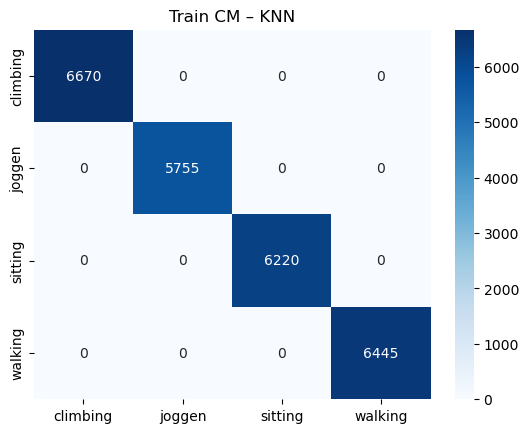


— Test —
Acc 0.9269 | Prec 0.9349 | Rec 0.9254 | F1 0.9223


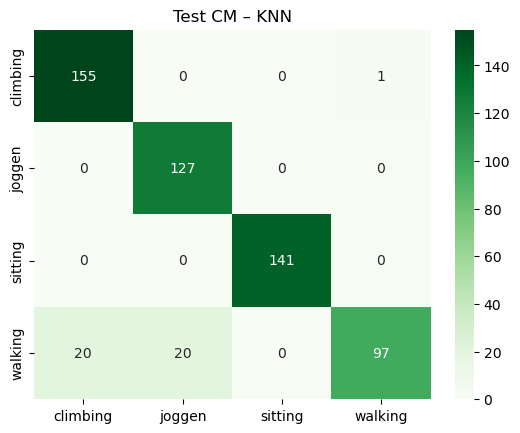

⚠️  Verdacht auf Overfitting   (ΔAcc=0.073, ΔF1=0.078)


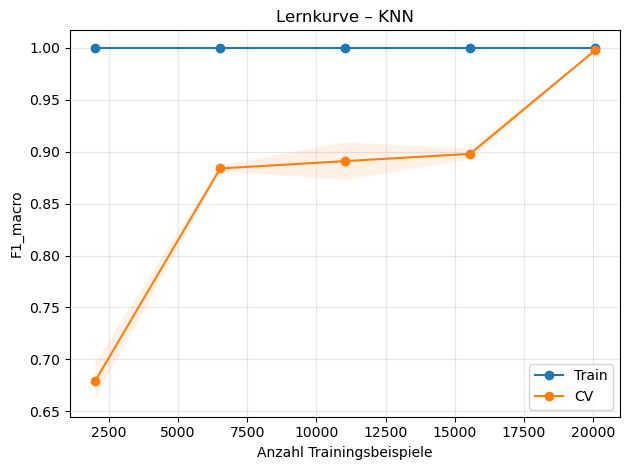

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# ---------------------------------------------------------------------------
# Zielvariablen kodieren (String → Integer)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# LabelEncoder an evaluate_model übergeben
evaluate_model.label_encoder = le

# ---------------------------------------------------------------------------
# Pipeline: Standardisierung + PCA + KNN
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', KNeighborsClassifier())
])

# ---------------------------------------------------------------------------
# Hyperparameter-Raster für KNN
param_grid_knn = {
    'clf__n_neighbors' : [5,7,9,11],
    'clf__weights'     : ['uniform', 'distance'],
    'clf__p'           : [1,2]
}


# ---------------------------------------------------------------------------
# GridSearchCV
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ---------------------------------------------------------------------------
# Training
grid_knn.fit(X_train, y_train_enc)
print("Beste Parameter:", grid_knn.best_params_)
print(f"Bester CV-Score (Accuracy): {grid_knn.best_score_:.4f}")

# Bestes Modell extrahieren
best_model = grid_knn.best_estimator_

# Evaluation und Speichern der Ergebnisse
evaluate_model("KNN", best_model, X_train, y_train_enc, X_test, y_test_enc)

##### **2.3.1 Ergebnisdiskussion - K-Nearest-Neighbors (KNN)**

Beim K-Nearest-Neighbors-Modell zeigt sich ein ausgeprägtes Overfitting-Verhalten: Während das Modell im Training perfekte Werte erzielt (Accuracy = 100,0%; F1 = 100,0%), fallen die Testkennzahlen deutlich ab auf eine Accuracy von 92,69% und einen F1-Score von 92,23%. Diese Generalisierungslücke von über 7% wird vom System zurecht als kritisches Overfitting identifiziert.

**Analyse der Confusion Matrices:**
- **Training:** Perfekte Klassifikation ohne jegliche Fehlklassifikationen
- **Test:** Deutliche Verwechslungen, insbesondere:
  - 1 "climbing" wird als "walking" klassifiziert
  - 20 "walking" werden als "climbing" klassifiziert  
  - 20 "walking" werden als "jogging" klassifiziert

**Ursachen für das starke Overfitting:**

1. **Niedriger k-Wert:** Mit k=11 bei distance-weighted KNN orientiert sich das Modell an sehr lokalen Nachbarschaften, was zu hoher Varianz führt. Wie IBM (2021) beschreibt:

   > "Lower values of k can overfit the data, whereas higher values of k tend to 'smooth out' the prediction values since it is averaging the values over a greater area, or neighborhood."

2. **Instanzbasierte Natur von KNN:** Da KNN die Trainingsinstanzen direkt speichert und für Vorhersagen nutzt, memorisiert es effektiv die Trainingsdaten, was bei perfekten Trainingsergebnissen ein klares Zeichen für Overfitting ist.

3. **Augmentierte Datenvariation:** Die durch Datenaugmentation eingeführten Positionsvariationen des Smartphones scheinen für KNN besonders herausfordernd zu sein, da ähnliche Bewegungsmuster durch unterschiedliche Orientierungen in verschiedene Regionen des Merkmalsraums verschoben werden.

**Lernkurven-Analyse:**
Die Lernkurve zeigt ein typisches Overfitting-Muster: konstant perfekte Training-Performance bei deutlich niedrigerer und langsam steigender CV-Performance. Selbst bei maximaler Datenmenge bleibt eine erhebliche Lücke zwischen Training (100%) und Kreuzvalidierung (~99%) bestehen.

**Spezifische Schwächen bei "walking":**
Die Confusion Matrix zeigt, dass besonders "walking" problematisch ist - 40 von 137 walking-Instanzen werden falsch klassifiziert (20 als "climbing", 20 als "jogging"). Dies ist nachvollziehbar, da "walking" natürliche Übergänge zu anderen Aktivitäten aufweist: beim Jogging können Gehpausen vorkommen, beim Climbing wird oft eine Strecke zu Fuss zurückgelegt. KNN hat Schwierigkeiten, diese fliessenden Aktivitätsübergänge robust zu unterscheiden, da es stark auf lokale Ähnlichkeiten angewiesen ist.

**Vergleich zu anderen Algorithmen:**
Im Vergleich zu Random Forest (1% Generalisierungslücke) und SVM (5% Generalisierungslücke) zeigt KNN mit 7% die schlechteste Generalisierungsfähigkeit. Dies bestätigt, dass instanzbasierte Methoden bei augmentierten Sensordaten weniger robust sind als Ensemble- oder Margin-basierte Ansätze.

**Fazit:**
KNN erweist sich als ungeeignet für diese Anwendung mit augmentierten Smartphone-Sensordaten. Die Methode memorisiert zu stark die Trainingsdaten und kann nicht robust auf die durch Augmentation eingeführten Variationen generalisieren.

**Quelle:**  
IBM, 2025: [What is the k-nearest neighbors algorithm?](https://www.ibm.com/think/topics/knn)

### **3. Modelvergleich**

In diesem letzten Teil werden wir die getesteten Modelle miteinander vergleichen und sie bewerten. Zum Abschluss wird noch Reflektiert.

#### **3.1 Überblick Modelvergleich**

In [10]:
model_metrics_df = pd.DataFrame(model_metrics)
print(model_metrics_df.head())

          Modell Train Accuracy Train Precision Train Recall Train F1-Score  \
0  Random Forest         0.9995          0.9995       0.9995         0.9995   
1            SVM         0.9947          0.9950       0.9950         0.9950   
2            KNN         1.0000          1.0000       1.0000         1.0000   

  Test Accuracy Test Precision Test Recall Test F1-Score  
0        0.9893         0.9892      0.9891        0.9889  
1        0.9447         0.9438      0.9459        0.9440  
2        0.9269         0.9349      0.9254        0.9223  


MODELLVERGLEICH: Random Forest vs. SVM vs. KNN

EXECUTIVE SUMMARY
--------------------------------------------------------------------------------
Rang     Modell          Test Acc   Overfitting Gap      Bewertung
--------------------------------------------------------------------------------
1.       Random Forest   98.93%     1.02%                EXZELLENT
2.       SVM             94.47%     5.00%                AKZEPTABEL
3.       KNN             92.69%     7.31%                PROBLEMATISCH



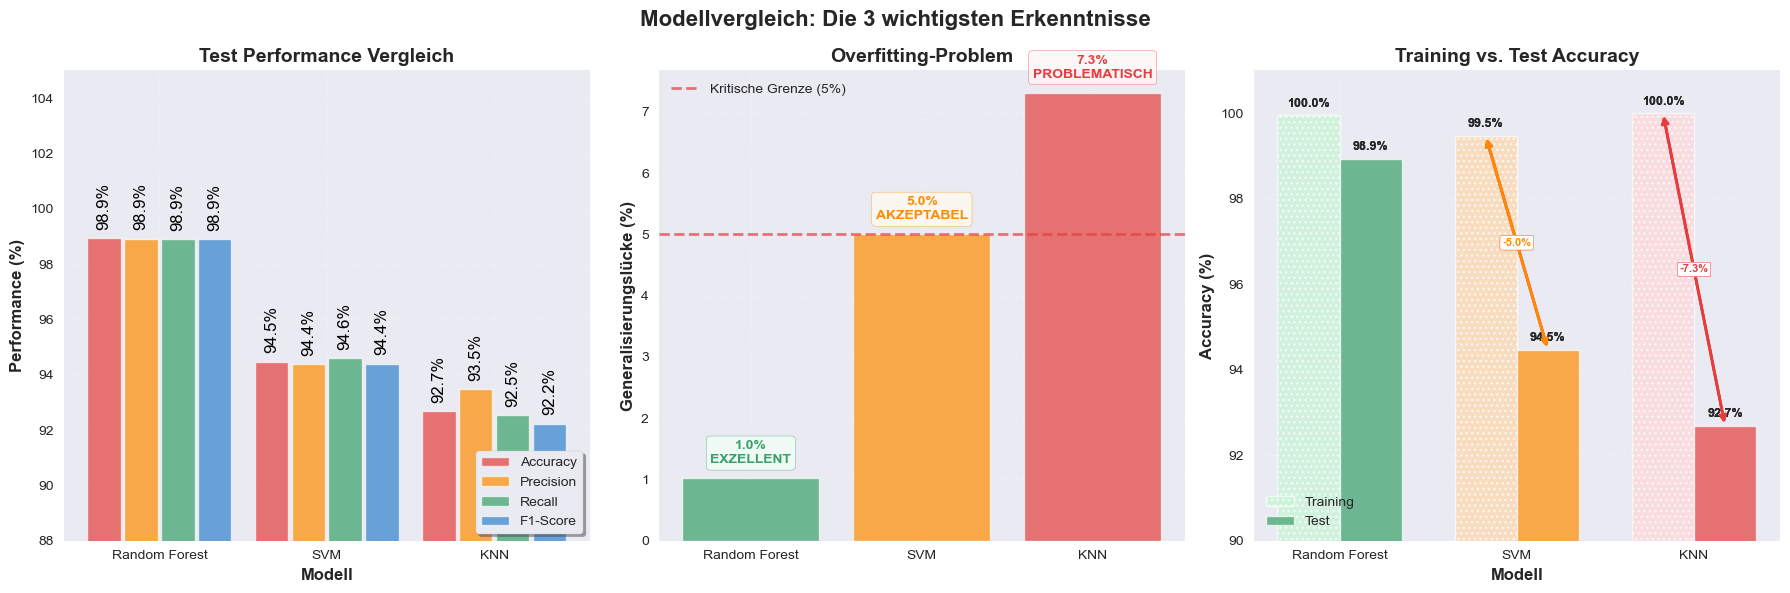

FAZIT
--------------------
🏆 SIEGER: Random Forest (98.93% Accuracy, 1.02% Gap)
⚠️  PROBLEM: KNN zeigt starkes Overfitting (7.31% Gap)
💡 EMPFEHLUNG: Random Forest für Produktiveinsatz verwenden


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style für bessere Plots
plt.style.use('seaborn-v0_8')
sns.set_palette("Set2")

# Verwende den existierenden model_metrics DataFrame
df = model_metrics_df.copy()

# Konvertiere String-Werte zu float für Berechnungen
for col in ['Train Accuracy', 'Train Precision', 'Train Recall', 'Train F1-Score', 
           'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']:
    df[col] = df[col].astype(float)

# Rename columns für einfachere Handhabung
df = df.rename(columns={
    'Train Accuracy': 'Train_Accuracy',
    'Train Precision': 'Train_Precision', 
    'Train Recall': 'Train_Recall',
    'Train F1-Score': 'Train_F1',
    'Test Accuracy': 'Test_Accuracy',
    'Test Precision': 'Test_Precision',
    'Test Recall': 'Test_Recall', 
    'Test F1-Score': 'Test_F1'
})

# Berechne Generalisierungslücken
df['Gap_Accuracy'] = (df['Train_Accuracy'] - df['Test_Accuracy']) * 100
df['Gap_F1'] = (df['Train_F1'] - df['Test_F1']) * 100

# Konvertiere zu Prozent für bessere Lesbarkeit
for col in ['Train_Accuracy', 'Train_Precision', 'Train_Recall', 'Train_F1', 
           'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']:
    df[col] = df[col] * 100

print("=" * 80)
print("MODELLVERGLEICH: Random Forest vs. SVM vs. KNN")
print("=" * 80)
print()

# Executive Summary Tabelle
print("EXECUTIVE SUMMARY")
print("-" * 80)
print(f"{'Rang':<8} {'Modell':<15} {'Test Acc':<10} {'Overfitting Gap':<20} {'Bewertung'}")
print("-" * 80)
for i, row in df.iterrows():
    rank = ["1.", "2.", "3."][i]
    status = ["EXZELLENT", "AKZEPTABEL", "PROBLEMATISCH"][i]
    print(f"{rank:<8} {row['Modell']:<15} {row['Test_Accuracy']:.2f}%{'':<4} {row['Gap_Accuracy']:.2f}%{'':<15} {status}")
print()

# Erstelle kompakte 1x3 Figure mit den wichtigsten Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Modellvergleich: Die 3 wichtigsten Erkenntnisse', fontsize=16, fontweight='bold')

# Farben für die Modelle
colors = ['#2E8B57', '#FF8C00', '#DC143C']  # Grün, Orange, Rot
model_names = df['Modell'].values

# Einheitliche moderne Farbpalette für alle Plots
rainbow_colors = ['#E53E3E', '#FF8C00', '#38A169', '#3182CE'] 
model_colors = ['#38A169', '#FF8C00', '#E53E3E']

# 1. Test Performance Vergleich (Hauptergebnis) - Gruppierte Balken
ax1 = axes[0]

model_positions = np.arange(len(model_names))
bar_width = 0.2
spacing = 0.02

# Alle wichtigen Test-Metriken gruppiert nach Modellen
metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Für jedes Modell alle Metriken nebeneinander
for i, model in enumerate(model_names):
    model_values = [df.iloc[i][metric] for metric in metrics]
    positions = model_positions[i] + np.arange(len(metrics)) * (bar_width + spacing)
    
    bars = ax1.bar(positions, model_values, bar_width, 
                   color=rainbow_colors, alpha=0.7, 
                   edgecolor='white', linewidth=1)
    
    # ALLE Werte auf Balken anzeigen - rotiert
    for j, (bar, value) in enumerate(zip(bars, model_values)):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                f'{value:.1f}%', ha='center', va='bottom', 
                fontsize=12, color='black', rotation=90)

# Modell-Labels unter den Gruppen
group_centers = model_positions + (len(metrics) - 1) * (bar_width + spacing) / 2
ax1.set_xticks(group_centers)
ax1.set_xticklabels(model_names)

# Metriken-Legende
legend_elements = [plt.Rectangle((0,0),1,1, facecolor=rainbow_colors[i], alpha=0.7, 
                                edgecolor='white', linewidth=1) 
                  for i in range(len(metric_labels))]
ax1.legend(legend_elements, metric_labels, loc='lower right', frameon=True, 
          fancybox=True, shadow=True)

ax1.set_xlabel('Modell', fontweight='bold', fontsize=12)
ax1.set_ylabel('Performance (%)', fontweight='bold', fontsize=12)
ax1.set_title('Test Performance Vergleich', fontweight='bold', fontsize=14)
ax1.set_ylim(88, 105)
ax1.grid(True, alpha=0.2, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 2. Overfitting-Analyse (Kernproblem) - farbige Modelle
ax2 = axes[1]
bars = ax2.bar(model_names, df['Gap_Accuracy'], color=model_colors, alpha=0.7, 
               edgecolor='white', linewidth=1)
ax2.set_ylabel('Generalisierungslücke (%)', fontweight='bold', fontsize=12)
ax2.set_title('Overfitting-Problem', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.2, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Klare Bewertung mit dezenten Hintergrundfarben
for i, (bar, gap) in enumerate(zip(bars, df['Gap_Accuracy'])):
    if gap < 2:
        label = 'EXZELLENT'
        text_color = '#38A169'  
        bg_color = '#F0FFF4'    
    elif gap < 6:
        label = 'AKZEPTABEL'
        text_color = '#FF8C00'  
        bg_color = '#FFFAF0'   
    else:
        label = 'PROBLEMATISCH'
        text_color = '#E53E3E' 
        bg_color = '#FFF5F5' 
    
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{gap:.1f}%\n{label}', ha='center', va='bottom', 
             fontweight='bold', color=text_color, fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor=bg_color, alpha=0.8, edgecolor=text_color))

# Gefahr-Linie bei 5%
ax2.axhline(y=5, color='#E53E3E', linestyle='--', alpha=0.7, label='Kritische Grenze (5%)', linewidth=2)
ax2.legend()

# 3. Train vs Test Accuracy (Overfitting Visualisierung) - farbige Modelle
ax3 = axes[2]
x = np.arange(len(model_names))
width = 0.35

bars1 = ax3.bar(x - width/2, df['Train_Accuracy'], width, label='Training', 
                color=['#C6F6D5', '#FED7AA', '#FED7D7'], alpha=0.7, edgecolor='white', linewidth=1,
                hatch='...', zorder=3)  # Punktmuster für Training
bars2 = ax3.bar(x + width/2, df['Test_Accuracy'], width, label='Test', 
                color=model_colors, alpha=0.7, edgecolor='white', linewidth=1, zorder=3)

ax3.set_xlabel('Modell', fontweight='bold', fontsize=12)
ax3.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
ax3.set_title('Training vs. Test Accuracy', fontweight='bold', fontsize=14)
ax3.set_xticks(x)
ax3.set_xticklabels(model_names)
ax3.legend()
ax3.set_ylim(90, 101)
ax3.grid(True, alpha=0.2, linestyle='--', zorder=1)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Werte und Gap-Anzeige
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Training Werte
    ax3.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.2, 
             f'{df.iloc[i]["Train_Accuracy"]:.1f}%', ha='center', fontweight='bold', fontsize=9, zorder=4)
    # Test Werte
    ax3.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.2, 
             f'{df.iloc[i]["Test_Accuracy"]:.1f}%', ha='center', fontweight='bold', fontsize=9, zorder=4)
    
    # Gap Pfeil zwischen den Balken
    gap_val = df.iloc[i]['Gap_Accuracy']
    if gap_val > 2:  # Nur bei relevanten Gaps
        ax3.annotate('', xy=(bar2.get_x() + bar2.get_width()/2, bar2.get_height()),
                    xytext=(bar1.get_x() + bar1.get_width()/2, bar1.get_height()),
                    arrowprops=dict(arrowstyle='<->', color=model_colors[i], lw=2), zorder=4)
        # Gap Wert in der Mitte
        mid_x = (bar1.get_x() + bar1.get_width()/2 + bar2.get_x() + bar2.get_width()/2) / 2
        mid_y = (bar1.get_height() + bar2.get_height()) / 2
        ax3.text(mid_x, mid_y, f'-{gap_val:.1f}%', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor=model_colors[i]),
                fontweight='bold', color=model_colors[i], fontsize=8, zorder=4)

# Werte und Gap-Anzeige
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Training Werte
    ax3.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.2, 
             f'{df.iloc[i]["Train_Accuracy"]:.1f}%', ha='center', fontweight='bold', fontsize=9)
    # Test Werte
    ax3.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.2, 
             f'{df.iloc[i]["Test_Accuracy"]:.1f}%', ha='center', fontweight='bold', fontsize=9)
    
    # Gap Pfeil zwischen den Balken
    gap_val = df.iloc[i]['Gap_Accuracy']
    if gap_val > 2:  # Nur bei relevanten Gaps
        ax3.annotate('', xy=(bar2.get_x() + bar2.get_width()/2, bar2.get_height()),
                    xytext=(bar1.get_x() + bar1.get_width()/2, bar1.get_height()),
                    arrowprops=dict(arrowstyle='<->', color='red', lw=2))
        # Gap Wert in der Mitte
        mid_x = (bar1.get_x() + bar1.get_width()/2 + bar2.get_x() + bar2.get_width()/2) / 2
        mid_y = (bar1.get_height() + bar2.get_height()) / 2
        ax3.text(mid_x, mid_y, f'-{gap_val:.1f}%', ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', edgecolor='red'),
                fontweight='bold', color='red', fontsize=8)

plt.tight_layout()
plt.show()

# Kompakte Zusammenfassung
print("FAZIT")
print("-" * 20)
print(f"🏆 SIEGER: Random Forest ({df.iloc[0]['Test_Accuracy']:.2f}% Accuracy, {df.iloc[0]['Gap_Accuracy']:.2f}% Gap)")
print(f"⚠️  PROBLEM: KNN zeigt starkes Overfitting ({df.iloc[2]['Gap_Accuracy']:.2f}% Gap)")
print(f"💡 EMPFEHLUNG: Random Forest für Produktiveinsatz verwenden")
print("=" * 80)